In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from statsmodels.tools.eval_measures import mse, rmse
from wordcloud import WordCloud
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn import tree
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn import neighbors
from IPython.display import Image


import pydotplus
from sklearn import ensemble

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')
import time

## Introduction

Customer Churn is an important consideration for most businesses to be able to understand and influence to keep growth and proftability healthy.  The simulated dataset used in this project describes customers with fifteen categorical variables and three continuous variables.  Those features are engineered and incorporated into several different models in an attmept to predict the boolean category Churn.      

## Data Exploration

In [3]:
#assign data frame
df_telco = (pd.read_excel('Data/Telco_Churn.xlsx'))

In [4]:
#examine the data frame

print(
    df_telco.head(),
    df_telco.info(),
    df_telco.describe()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
#change TotalCharges from dtype 'object' to 'float64'

df_telco.TotalCharges=pd.to_numeric(df_telco.TotalCharges, errors='coerce')

In [6]:
#change SeniorCitizen to dtype to 'uint8' (as it is binary)

df_telco.SeniorCitizen = df_telco.SeniorCitizen.astype('uint8')

In [7]:
#Check for missing values

missing_values_ratios = (df_telco.isnull().sum()/df_telco.isnull().count())
missing_values_ratios.sort_values(ascending=False).head()

TotalCharges      0.001562
Churn             0.000000
OnlineSecurity    0.000000
gender            0.000000
SeniorCitizen     0.000000
dtype: float64

In [8]:
#v low percantage of missing values; drop them

df_telco.dropna(inplace=True)

In [9]:
#get value counts of the target

df_telco['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [10]:
#Make a boolean version of the target for algorithmic friendliness
churn_bool = []

for idx, val in enumerate(df_telco['Churn']):
    if val == 'Yes':
        churn_bool.append(1)
    else:
        churn_bool.append(0)
        
df_telco['churn_bool'] = churn_bool

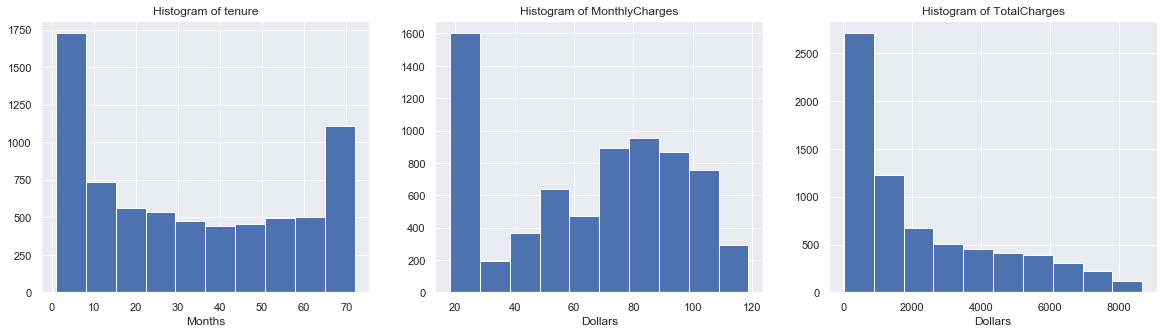

In [11]:
#plot histograms of the target and the three numeric variables

plt.figure(figsize=(20,5))

#plt.subplot(2,2,1)
#plt.hist(df_telco.churn_bool)
#plt.title("Histogram of {} (this is the target variable))".format("churn_bool"))

plt.subplot(1,3,1)
plt.hist(df_telco.tenure)
plt.title("Histogram of {}".format("tenure"))
plt.xlabel('Months')

plt.subplot(1,3,2)
plt.hist(df_telco.MonthlyCharges)
plt.title("Histogram of {}".format("MonthlyCharges"))
plt.xlabel('Dollars')

plt.subplot(1,3,3)
plt.hist(df_telco.TotalCharges)
plt.title("Histogram of {}".format("TotalCharges"))
plt.xlabel('Dollars')
plt.show()

In [12]:
#perform a boxcox transformation on the continuous variables

df_telco['tenure_boxcox'],_ = boxcox(df_telco.tenure)
df_telco['MonthlyCharges_boxcox'],_ = boxcox(df_telco.MonthlyCharges)
df_telco['TotalCharges_boxcox'],_ = boxcox(df_telco.TotalCharges)

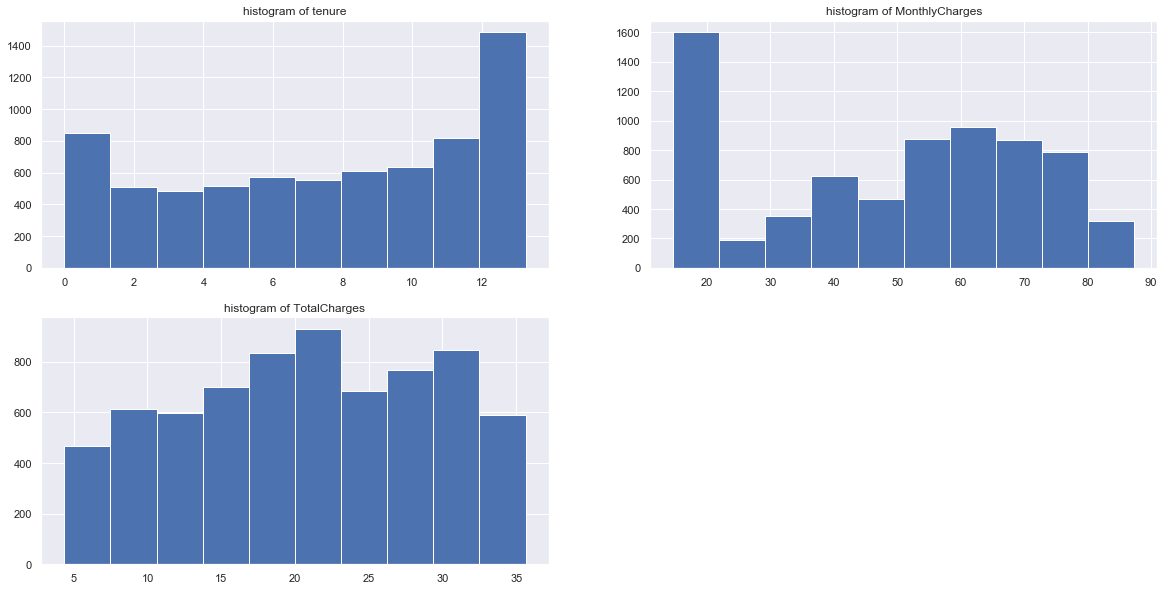

In [13]:
#visualize the boxcox transformations of the three numeric variables

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.hist(df_telco.tenure_boxcox)
plt.title("histogram of {}".format("tenure"))

plt.subplot(2,2,2)
plt.hist((df_telco.MonthlyCharges_boxcox))
plt.title("histogram of {}".format("MonthlyCharges"))

plt.subplot(2,2,3)
plt.hist((df_telco.TotalCharges_boxcox))
plt.title("histogram of {}".format("TotalCharges"))
plt.show()

In [14]:
#setting up for visualization of 'object' variables

cols = [col for col in df_telco.select_dtypes(['object','uint8']) if col not in ['customerID', 'Churn']]
df_telco2 = df_telco[cols]
df_telco2['churn_bool'] = churn_bool


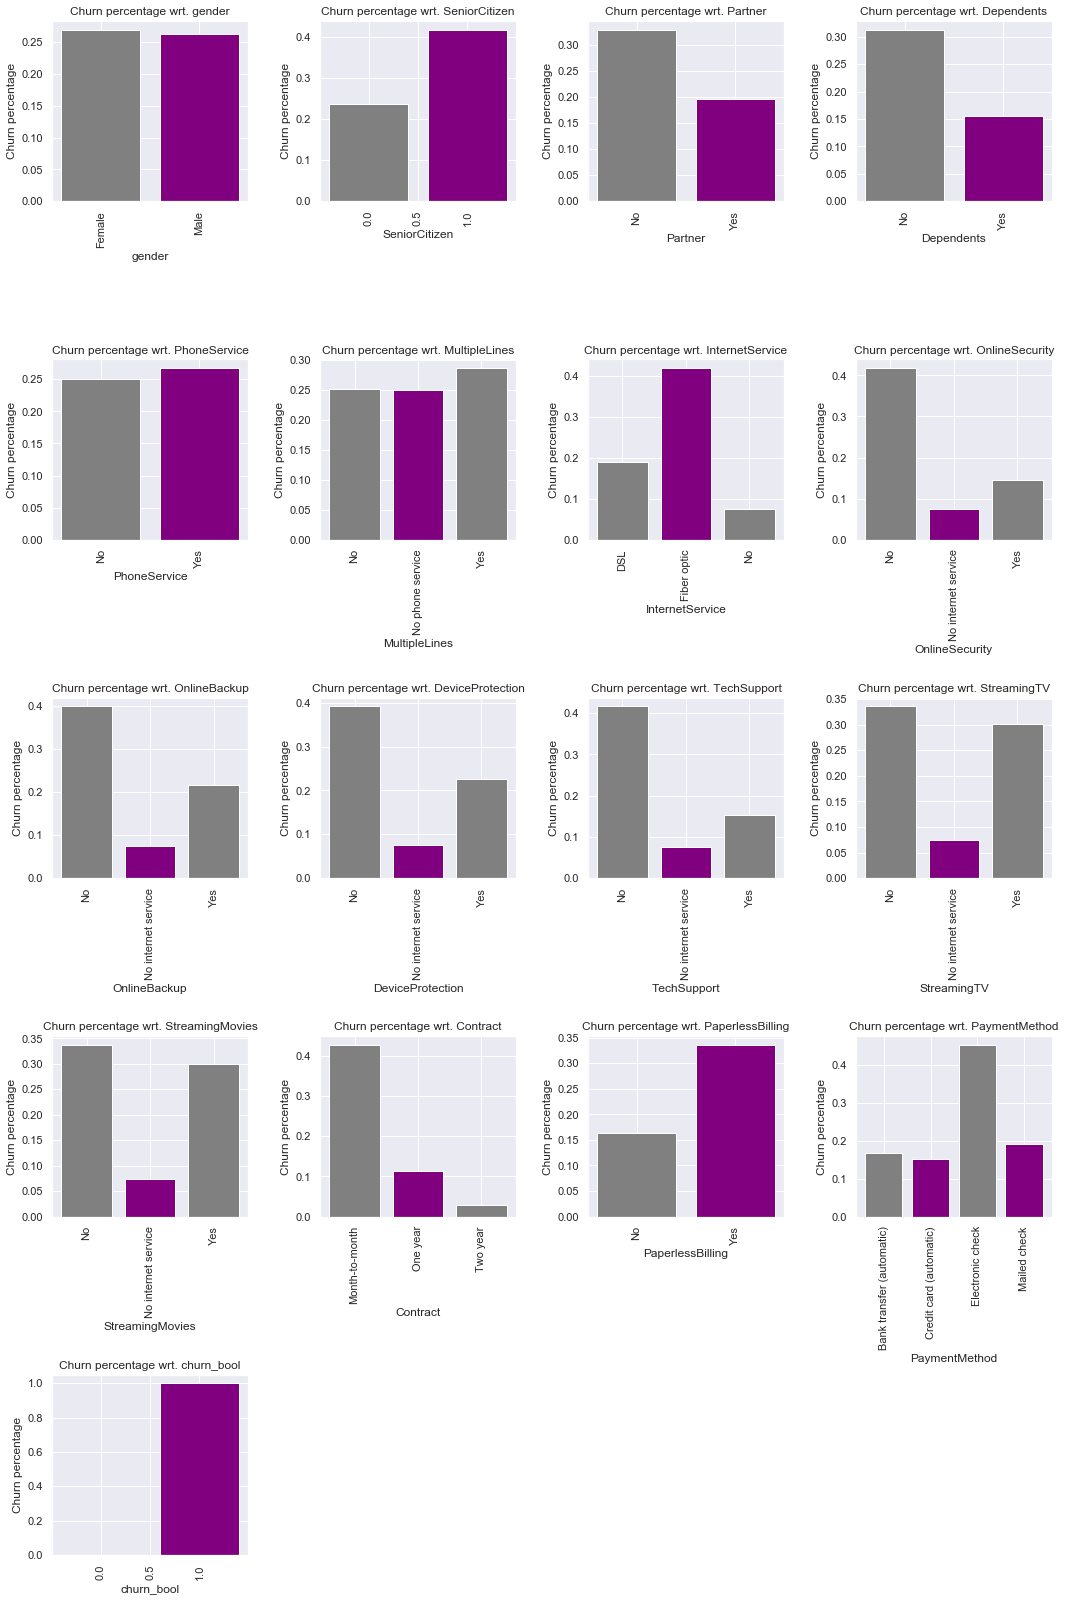

In [15]:
#plot bar graphs of the object variables

plt.figure(figsize=(15,50))

for index, column in enumerate(df_telco2):
    plt.subplot(11,4,index+1)
    plt.bar(df_telco2.groupby(column)["churn_bool"].mean().index, df_telco2.groupby(column)["churn_bool"].mean(),
           color=("grey","purple"))
    plt.title("Churn percentage wrt. {}".format(column))
    plt.ylabel("Churn percentage")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

## Feature Engineering

In [16]:
#make dummy variables from the object variables

df_telco = pd.concat([df_telco,pd.get_dummies(
    df_telco[['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService',
                'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
                'StreamingMovies','Contract','PaperlessBilling','PaymentMethod']], drop_first=True)], axis=1)


In [17]:
#check the correlation of various features with the target

np.abs(df_telco[df_telco.select_dtypes(['int64', 'float64', 'uint8']).columns].iloc[:,1:].corr().loc[:,'churn_bool']).sort_values(ascending=False).head(35)

#NTS: the ^above^ logic fails if the target is categorical

churn_bool                               1.000000
tenure_boxcox                            0.374174
tenure                                   0.354049
InternetService_Fiber optic              0.307463
Contract_Two year                        0.301552
PaymentMethod_Electronic check           0.301455
TotalCharges_boxcox                      0.236815
TechSupport_No internet service          0.227578
OnlineSecurity_No internet service       0.227578
OnlineBackup_No internet service         0.227578
DeviceProtection_No internet service     0.227578
StreamingTV_No internet service          0.227578
StreamingMovies_No internet service      0.227578
InternetService_No                       0.227578
TotalCharges                             0.199484
MonthlyCharges_boxcox                    0.194624
MonthlyCharges                           0.192858
PaperlessBilling_Yes                     0.191454
Contract_One year                        0.178225
OnlineSecurity_Yes                       0.171270


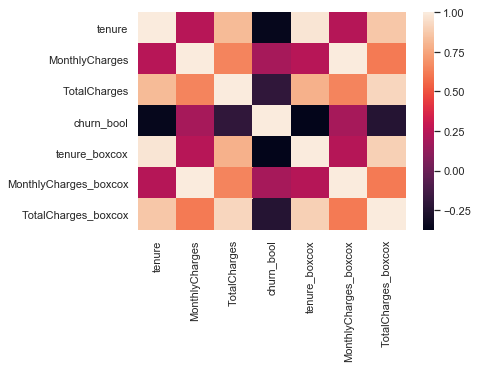

In [18]:
sns.heatmap(df_telco.select_dtypes(['int64', 'float64']).corr())

In [19]:
#assigning features

#X is standardized
X = StandardScaler().fit_transform(pd.concat([df_telco[['tenure_boxcox','MonthlyCharges_boxcox','TotalCharges_boxcox']], 
                                              df_telco.select_dtypes(['uint8'])], axis=1, sort=False)
                                  )

#XX is the same data as X but not standardized
XX = pd.concat([df_telco[['tenure_boxcox', 'MonthlyCharges_boxcox','TotalCharges_boxcox']], 
                df_telco.select_dtypes(['uint8'])], axis=1, sort=False
              )

#Y is the target
Y = df_telco.churn_bool

In [20]:
#NTS: these functions are useful diagnostic tools

#np.isinf(X).any()
#np.isinf(Y).any()

#np.isnan(X).any()
#np.isnan(Y).any()

For comparision, two feature sets are engineered.  The first feature set will use PCA, and the second will use SelectKBest.

## Feature Engineering: PCA

In [21]:
#setting up parameters for GridSearchCV(X)... the plan is PCA(GridSearchCV(X))

n_comps = np.arange(0, 25)
param_grid_pca = [{'pca__n_components':n_comps}]
pipe_tree_pca = make_pipeline(PCA())

In [22]:
gs_pca = GridSearchCV(pipe_tree_pca, param_grid=param_grid_pca, cv=10)

In [52]:
gs_pca.fit(X,Y)
print(gs_pca.best_params_)

ValueError: array must not contain infs or NaNs

In [23]:
#using the results of GridSearchCV to perform PCA

sklearn_pca = PCA(n_components=22)  
X_pca = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA:\n',
    sklearn_pca.explained_variance_ratio_
)

#X_pca is now our PCA engineered feature set.

The percentage of total variance in the dataset explained by each component from Sklearn PCA:
 [3.31842341e-01 1.19866458e-01 8.98165287e-02 4.77221792e-02
 4.16126789e-02 4.12633978e-02 3.78085715e-02 3.33596922e-02
 3.13799130e-02 2.96360092e-02 2.66083095e-02 2.38330588e-02
 2.26682792e-02 2.05405597e-02 2.02421265e-02 1.80819458e-02
 1.56008299e-02 1.53408924e-02 1.46270378e-02 9.20900330e-03
 8.64470384e-03 2.64931253e-04]


## Feature Engineering: SelectKBest

In [24]:
#SelectKBest contrasts with PCA as a feature selection tool

selection = SelectKBest(score_func=f_regression, k='all') 
X_kbest = selection.fit(XX, Y).transform(XX)

#we can compare the performance of models with a PCA derived feature set (X_pca(X)),
#    vs a SelectKBest derived feature set (X_kbest(XX))

## Splitting and Resampling Data

In [26]:
from imblearn.over_sampling import SMOTE
#splitting the data into testing and training sets
X_train_skb, X_test_skb, Y_train_skb, Y_test_skb = train_test_split(
    X_kbest, Y, test_size = 0.20, random_state = 1
)

X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(
    X_pca, Y, test_size = 0.20, random_state = 1
)

#resampling the data to deal with class imbalance
X_resampled_train_skb, Y_resampled_train_skb = SMOTE().fit_resample(X_train_skb, Y_train_skb)
X_resampled_train_pca, Y_resampled_train_pca = SMOTE().fit_resample(X_train_pca, Y_train_pca)

## Model 1: Decision Tree(SelectKBest)

In [34]:
#setting up parameters for GridSearchCV(DecisionTreeClassifier())

depths = np.arange(1, 25)
num_features = [1, 2, 3, 4, 5, 6, 7, 8]

param_grid_dt_skb = [{'decisiontreeclassifier__max_depth':depths,
               'decisiontreeclassifier__max_features':num_features}]

pipe_tree_dt_skb = make_pipeline(tree.DecisionTreeClassifier(criterion='entropy'))

In [35]:
gs_dt_skb = GridSearchCV(pipe_tree_dt_skb, param_grid=param_grid_dt_skb, cv=10)

In [36]:
gs_dt_skb.fit(X_resampled_train_skb,Y_resampled_train_skb)
print(gs_dt_skb.best_params_)

{'decisiontreeclassifier__max_depth': 16, 'decisiontreeclassifier__max_features': 8}


In [37]:
#initialize and train the decision tree model using GridSearchCV results
#    {'decisiontreeclassifier__max_depth': 16, 'decisiontreeclassifier__max_features': 8}

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=8,
    max_depth=16
)

decision_tree.fit(X_resampled_train_skb, Y_resampled_train_skb)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=16,
                       max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [38]:
#making predictions for model evaluation
Y_pred_dt_skb = decision_tree.fit(X_resampled_train_skb, Y_resampled_train_skb).predict(X_test_skb)

In [39]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()
print(cross_val_score(decision_tree, X_resampled_train_skb, Y_resampled_train_skb, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(decision_tree, X_resampled_train_skb, Y_resampled_train_skb, cv=10).mean())
print("--- %s seconds ---" % (time.time() - start_time))

[0.68401937 0.71670702 0.71966019 0.77063107 0.86286408 0.87257282
 0.86286408 0.88592233 0.87378641 0.86771845]
The 10-fold cross validation average for the training set is  0.8151972307764639
--- 0.35196518898010254 seconds ---


In [40]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(decision_tree, X_test_skb, Y_test_skb, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(decision_tree, X_test_skb, Y_test_skb, cv=10).mean())

[0.69014085 0.76595745 0.70212766 0.73049645 0.75177305 0.76595745
 0.72142857 0.76428571 0.80714286 0.72857143]
The 10-fold cross validation average for the testing set  is  0.7356156085448863


In [41]:
#classification report

print(classification_report(Y_test_skb, Y_pred_dt_skb, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1041
           1       0.51      0.61      0.55       366

    accuracy                           0.74      1407
   macro avg       0.68      0.70      0.69      1407
weighted avg       0.76      0.74      0.75      1407



In [42]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(Y_test_skb, Y_pred_dt_skb, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[823 218]
 [142 224]]


## Model 2: Decision Tree(PCA)

In [180]:
#setting up parameters for GridSearchCV(DecisionTreeClassifier())

depths = np.arange(1, 25)
num_features = [1, 2, 3, 4, 5, 6, 7, 8]

param_grid_dt_pca = [{'decisiontreeclassifier__max_depth':depths,
               'decisiontreeclassifier__max_features':num_features}]

pipe_tree_dt_pca = make_pipeline(tree.DecisionTreeClassifier(criterion='entropy'))

In [181]:
gs_dt_pca = GridSearchCV(pipe_tree_dt_pca, param_grid=param_grid_dt_pca, cv=10)

In [182]:
gs_dt_pca.fit(X_resampled_train_pca,Y_resampled_train_pca)
print(gs_dt_pca.best_params_)

{'decisiontreeclassifier__max_depth': 20, 'decisiontreeclassifier__max_features': 7}


In [183]:
#initialize and train the decision tree model using GridSearchCV results
#    {'decisiontreeclassifier__max_depth': 20, 'decisiontreeclassifier__max_features': 7}

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=7,
    max_depth=20
)

decision_tree.fit(X_resampled_train_pca, Y_resampled_train_pca)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [184]:
#making predictions for model evaluation
Y_pred_dt_pca = decision_tree.fit(X_resampled_train_pca, Y_resampled_train_pca).predict(X_test_pca)

In [185]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(decision_tree, X_resampled_train_pca, Y_resampled_train_pca, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(decision_tree, X_resampled_train_pca, Y_resampled_train_pca, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.73607748 0.77966102 0.74150485 0.75728155 0.82038835 0.79368932
 0.81432039 0.78762136 0.79004854 0.7961165 ]
The 10-fold cross validation average for the training set is  0.7778000775758716
--- 1.8795490264892578 seconds ---


In [186]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(decision_tree, X_test_pca, Y_test_pca, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(decision_tree, X_test_pca, Y_test_pca, cv=10).mean())

[0.71126761 0.75177305 0.67375887 0.78014184 0.75886525 0.71631206
 0.8        0.75714286 0.78571429 0.76428571]
The 10-fold cross validation average for the testing set  is  0.7484823836636842


In [187]:
#classification report

print(classification_report(Y_test_pca, Y_pred_dt_pca, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      1041
           1       0.46      0.60      0.52       366

    accuracy                           0.71      1407
   macro avg       0.65      0.68      0.66      1407
weighted avg       0.74      0.71      0.72      1407



In [188]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(Y_test_pca, Y_pred_dt_pca, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[777 264]
 [145 221]]


In the classification reports, a value of 1 corresponds to a value of "Yes" for the target variable "Churn", and 0 corresponds to a "No."  Across all models built, values of "Yes" proved more difficult to capture accurately than "No" values ("No" is the dominant class of our target as shown above in the Data Exploration section).  These decision tree models show above average performance compared to the other models built in this project.  One disadvantage of decision trees is that they are biased towards the dominant class. This issue was addressed by implementing SMOTE resampling, although the prediction of the dominant class is still much better in these models.  The SelectKBest feature set outperformed the PCA feature set slightly. Decison Trees handle varied data types well, and are easy to implement and visulaize, making this model a good choice overall.

## Model 3: Random Forest Classifier(SelectKBest)

In [56]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_resampled_train_skb,Y_resampled_train_skb)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [57]:
#making predictions for model evaluation
Y_preds_rfc_skb=rfc.predict(X_test_skb)

In [58]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()
print(cross_val_score(rfc, X_resampled_train_skb, Y_resampled_train_skb, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(rfc, X_resampled_train_skb, Y_resampled_train_skb, cv=10).mean())
print("--- %s seconds ---" % (time.time() - start_time))

[0.69975787 0.71670702 0.70752427 0.78762136 0.91868932 0.92597087
 0.9368932  0.94296117 0.94174757 0.94174757]
The 10-fold cross validation average for the training set is  0.8500208632078798
--- 1.548774242401123 seconds ---


In [59]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(rfc, X_test_skb, Y_test_skb, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(rfc, X_test_skb, Y_test_skb, cv=10).mean())

[0.77464789 0.75886525 0.76595745 0.81560284 0.73049645 0.79432624
 0.78571429 0.79285714 0.82857143 0.79285714]
The 10-fold cross validation average for the testing set  is  0.77403028097664


In [60]:
#classification report
print(classification_report(Y_test_skb, Y_preds_rfc_skb, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1041
           1       0.58      0.46      0.52       366

    accuracy                           0.77      1407
   macro avg       0.70      0.67      0.68      1407
weighted avg       0.76      0.77      0.76      1407



In [61]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(Y_test_skb, Y_preds_rfc_skb, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[918 123]
 [196 170]]


## Model 4: Random Forest Classifier(PCA)

In [62]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_resampled_train_pca,Y_resampled_train_pca)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [63]:
#making predictions for model evaluation
Y_preds_rfc_pca=rfc.predict(X_test_pca)

In [64]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(rfc, X_resampled_train_pca, Y_resampled_train_pca, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(rfc, X_resampled_train_pca, Y_resampled_train_pca, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.80750605 0.80266344 0.78762136 0.81796117 0.85072816 0.8434466
 0.87014563 0.87135922 0.84708738 0.84708738]
The 10-fold cross validation average for the training set is  0.8274121982181057
--- 4.479430913925171 seconds ---


In [65]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(rfc, X_test_pca, Y_test_pca, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(rfc, X_test_pca, Y_test_pca, cv=10).mean())

[0.78873239 0.77304965 0.72340426 0.75886525 0.78723404 0.77304965
 0.81428571 0.77142857 0.81428571 0.72857143]
The 10-fold cross validation average for the testing set  is  0.7833007263438788


In [66]:
#classification report

print(classification_report(Y_test_pca, Y_preds_rfc_pca, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1041
           1       0.53      0.55      0.54       366

    accuracy                           0.75      1407
   macro avg       0.68      0.69      0.69      1407
weighted avg       0.76      0.75      0.76      1407



In [67]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(Y_test_pca, Y_preds_rfc_pca, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[861 180]
 [165 201]]


Both Random Forest models performed well on the dominant class, but had low values for precision and recall of the minority class.  The PCA feature set handily outperforms the SelectKBest set for this model.  Due to the lower minority class performance and the resource intensive, black box nature of the Random Forest, these models are more difficult to recommend.  

## Model 5: SVM(SelectKBest)

In [168]:
#kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = [1,2]
param_grid_svm_skb = [{'svc__degree':degrees}]
pipe_tree_svm_skb = make_pipeline(SVC(kernel = 'poly'))

In [169]:
gs_svm = GridSearchCV(pipe_tree_svm_skb, param_grid=param_grid_svm_skb, cv=10)

#gs_svm.get_params().keys()

In [170]:
gs_svm.fit(X_resampled_train_skb,Y_resampled_train_skb)
print(gs_svm.best_params_)

{'svc__degree': 1}


In [70]:
svm = SVC(kernel='poly',degree=1)
svm.fit(X_resampled_train_skb, Y_resampled_train_skb)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [71]:
#Setting the predictions for analysis
Y_pred_svm_skb = svm.fit(X_resampled_train_skb, Y_resampled_train_skb).predict(X_test_skb)

In [73]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()
print(cross_val_score(svm, X_resampled_train_skb, Y_resampled_train_skb, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(svm, X_resampled_train_skb, Y_resampled_train_skb, cv=10).mean())
print("--- %s seconds ---" % (time.time() - start_time))

[0.76755448 0.75423729 0.75       0.75970874 0.77548544 0.77427184
 0.77548544 0.74514563 0.76941748 0.77548544]
The 10-fold cross validation average for the training set is  0.7646791767554479
--- 47.49872303009033 seconds ---


In [74]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(svm, X_test_skb, Y_test_skb, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(svm, X_test_skb, Y_test_skb, cv=10).mean())

[0.80985915 0.78014184 0.77304965 0.81560284 0.79432624 0.77304965
 0.8        0.78571429 0.79285714 0.8       ]
The 10-fold cross validation average for the testing set  is  0.7924600796266963


In [75]:
#classification report

print(classification_report(Y_test_skb, Y_pred_svm_skb, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.92      0.71      0.81      1041
           1       0.51      0.83      0.63       366

    accuracy                           0.74      1407
   macro avg       0.71      0.77      0.72      1407
weighted avg       0.81      0.74      0.76      1407



In [42]:
#confusion matrix
print('SVM confusion matrix:', '\n', 
      confusion_matrix(Y_test_skb, Y_pred_svm_skb, labels=None, sample_weight=None)
     )

NameError: name 'Y_test_skb' is not defined

## Model 6: SVM(PCA)

In [171]:
#kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = [1,2]
param_grid_svm_pca = [{'svc__degree':degrees}]
pipe_tree_svm_pca = make_pipeline(SVC(kernel = 'poly'))

In [172]:
gs_svm_pca = GridSearchCV(pipe_tree_svm_pca, param_grid=param_grid_svm_pca, cv=10)

#gs_svm.get_params().keys()

In [173]:
gs_svm_pca.fit(X_resampled_train_pca,Y_resampled_train_pca)
print(gs_svm_pca.best_params_)

{'svc__degree': 1}


In [80]:
svm = SVC(kernel='poly',degree=1)
svm.fit(X_resampled_train_pca, Y_resampled_train_pca)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [81]:
#Setting the predictions for analysis
Y_pred_svm_pca = svm.fit(X_resampled_train_pca, Y_resampled_train_pca).predict(X_test_pca)

In [82]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(svm, X_resampled_train_pca, Y_resampled_train_pca, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(svm, X_resampled_train_pca, Y_resampled_train_pca, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.77239709 0.7566586  0.75728155 0.75485437 0.76334951 0.77063107
 0.78398058 0.76820388 0.77184466 0.78276699]
The 10-fold cross validation average for the training set is  0.7681968311431862
--- 25.259382963180542 seconds ---


In [83]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(svm, X_test_pca, Y_test_pca, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(svm, X_test_pca, Y_test_pca, cv=10).mean())

[0.79577465 0.72340426 0.80141844 0.80851064 0.79432624 0.77304965
 0.82857143 0.78571429 0.85       0.79285714]
The 10-fold cross validation average for the testing set  is  0.7953626724888336


In [84]:
#classification report

print(classification_report(Y_test_pca, Y_pred_svm_pca, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1041
           1       0.51      0.82      0.63       366

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.72      1407
weighted avg       0.82      0.75      0.77      1407



In [85]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(Y_test_pca, Y_pred_svm_pca, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[757 284]
 [ 65 301]]


Of all the models in this report, SVM has the best classification report and is the most robust.  It is fairly resource intensive when compared to some of the other models, with the PCA feature set outperforming the SelectKBest set by roughly a factor of two for this parameter.

## Model 7: Naive Bayes(SelectKBest)


In [96]:
# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(X_resampled_train_skb, Y_resampled_train_skb)

# Classify, storing the result in a new variable.
Y_preds_nb_skb = bnb.predict(X_test_skb)

In [97]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(bnb, X_resampled_train_skb, Y_resampled_train_skb, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(bnb, X_resampled_train_skb, Y_resampled_train_skb, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.73728814 0.71549637 0.72087379 0.75485437 0.72694175 0.7342233
 0.75121359 0.70995146 0.74757282 0.73786408]
The 10-fold cross validation average for the training set is  0.7336279649263029
--- 0.16277098655700684 seconds ---


In [98]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(bnb, X_test_skb, Y_test_skb, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(bnb, X_test_skb, Y_test_skb, cv=10).mean())

[0.72535211 0.74468085 0.67375887 0.81560284 0.72340426 0.78014184
 0.77142857 0.75       0.76428571 0.67857143]
The 10-fold cross validation average for the testing set  is  0.742722647944404


In [99]:
#classification report

print(classification_report(Y_test_skb, Y_preds_nb_skb, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.93      0.59      0.72      1041
           1       0.43      0.87      0.57       366

    accuracy                           0.67      1407
   macro avg       0.68      0.73      0.65      1407
weighted avg       0.80      0.67      0.69      1407



In [100]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(Y_test_skb, Y_preds_nb_skb, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[619 422]
 [ 49 317]]


## Model 8: Naive Bayes(PCA)

In [101]:
# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(X_resampled_train_pca, Y_resampled_train_pca)

# Classify, storing the result in a new variable.
Y_preds_nb_pca = bnb.predict(X_test_pca)

In [102]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(bnb, X_resampled_train_pca, Y_resampled_train_pca, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(bnb, X_resampled_train_pca, Y_resampled_train_pca, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.71428571 0.69854722 0.67961165 0.69053398 0.72572816 0.72572816
 0.71966019 0.70873786 0.72087379 0.70024272]
The 10-fold cross validation average for the training set is  0.7083949434636451
--- 0.1382429599761963 seconds ---


In [103]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(bnb, X_test_pca, Y_test_pca, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(bnb, X_test_pca, Y_test_pca, cv=10).mean())

[0.80985915 0.70212766 0.72340426 0.79432624 0.75177305 0.75177305
 0.75       0.77142857 0.86428571 0.82142857]
The 10-fold cross validation average for the testing set  is  0.7740406267391583


In [104]:
#classification report

print(classification_report(Y_test_pca, Y_preds_nb_pca, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80      1041
           1       0.48      0.71      0.57       366

    accuracy                           0.72      1407
   macro avg       0.68      0.72      0.68      1407
weighted avg       0.77      0.72      0.74      1407



In [105]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(Y_test_pca, Y_preds_nb_pca, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[758 283]
 [107 259]]


The Naive Bayes PCA model performed well, but the SelectKBest model was fairly unbalanced.  This may be because the PCA feature set does a better job of engineering variable independence, which is preferred by Naive Bayes models.  Overall, the Naive Bayes PCA model is one of the best in the report. Although the classification report here is not quite as strong as the SVM model, the simple and fast nature of the Naive Bayes model combined with its above average classification performance makes it a strong contender.

## Model 9: KNN(SelectKBest)

In [149]:
#kernels = ['linear', 'poly', 'rbf', 'sigmoid']
num_neighbors = np.arange(1, 25)
weights = ['distance','uniform']
leaf_sizes = np.arange(1, 40)

param_grid_knn_skb = [{'kneighborsclassifier__n_neighbors':num_neighbors,
                      'kneighborsclassifier__weights':weights,
                      'kneighborsclassifier__leaf_size':leaf_sizes}
                     ]
pipe_tree_knn_skb = make_pipeline(neighbors.KNeighborsClassifier())

In [150]:
gs_knn_skb = GridSearchCV(pipe_tree_knn_skb, param_grid=param_grid_knn_skb, cv=10)

#gs_knn_skb.get_params().keys()

In [151]:
gs_knn_skb.fit(X_resampled_train_skb,Y_resampled_train_skb)
print(gs_knn_skb.best_params_)

{'kneighborsclassifier__leaf_size': 4, 'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'distance'}


In [152]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1, weights='distance', leaf_size=4)
knn.fit(X_resampled_train_skb, Y_resampled_train_skb)

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='distance')

In [153]:
# Classify, storing the result in a new variable.
Y_preds_knn_skb = knn.predict(X_test_skb)

In [154]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(knn, X_resampled_train_skb, Y_resampled_train_skb, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(knn, X_resampled_train_skb, Y_resampled_train_skb, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.8062954  0.83535109 0.84466019 0.85194175 0.86650485 0.84708738
 0.87985437 0.85800971 0.86286408 0.87257282]
The 10-fold cross validation average for the training set is  0.8525141634735183
--- 0.5048840045928955 seconds ---


In [155]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(knn, X_test_skb, Y_test_skb, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(knn, X_test_skb, Y_test_skb, cv=10).mean())

[0.71830986 0.71631206 0.70921986 0.74468085 0.70212766 0.75886525
 0.73571429 0.72142857 0.77142857 0.72857143]
The 10-fold cross validation average for the testing set  is  0.7306658390056653


In [156]:
#classification report

print(classification_report(Y_test_skb, Y_preds_knn_skb, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1041
           1       0.46      0.58      0.51       366

    accuracy                           0.71      1407
   macro avg       0.65      0.67      0.65      1407
weighted avg       0.74      0.71      0.72      1407



In [157]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(Y_test_skb, Y_preds_knn_skb, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[789 252]
 [153 213]]


## Model 10: KNN(PCA)

In [158]:
#kernels = ['linear', 'poly', 'rbf', 'sigmoid']
num_neighbors = np.arange(1, 25)
weights = ['distance','uniform']
leaf_sizes = np.arange(1, 40)

param_grid_knn_pca = [{'kneighborsclassifier__n_neighbors':num_neighbors,
                      'kneighborsclassifier__weights':weights,
                      'kneighborsclassifier__leaf_size':leaf_sizes}
                     ]
pipe_tree_knn_pca = make_pipeline(neighbors.KNeighborsClassifier())

In [159]:
gs_knn_pca = GridSearchCV(pipe_tree_knn_pca, param_grid=param_grid_knn_pca, cv=10)

#gs_knn_pca.get_params().keys()

In [160]:
gs_knn_pca.fit(X_resampled_train_pca,Y_resampled_train_pca)
print(gs_knn_pca.best_params_)

{'kneighborsclassifier__leaf_size': 29, 'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'distance'}


In [161]:
#{'kneighborsclassifier__leaf_size': 29, 'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'distance'}
knn = neighbors.KNeighborsClassifier(n_neighbors=1, weights='distance', leaf_size=29)
knn.fit(X_resampled_train_pca, Y_resampled_train_pca)

KNeighborsClassifier(algorithm='auto', leaf_size=29, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='distance')

In [162]:
# Classify, storing the result in a new variable.
Y_preds_knn_pca = knn.predict(X_test_pca)

In [163]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(knn, X_resampled_train_pca, Y_resampled_train_pca, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(knn, X_resampled_train_pca, Y_resampled_train_pca, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.80992736 0.80387409 0.80582524 0.82281553 0.86650485 0.84587379
 0.8592233  0.85315534 0.86529126 0.85194175]
The 10-fold cross validation average for the training set is  0.8384432520745669
--- 0.9935920238494873 seconds ---


In [164]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(knn, X_test_pca, Y_test_pca, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(knn, X_test_pca, Y_test_pca, cv=10).mean())

[0.74647887 0.71631206 0.70921986 0.70921986 0.73049645 0.75886525
 0.77142857 0.78571429 0.78571429 0.66428571]
The 10-fold cross validation average for the testing set  is  0.7377735205559599


In [165]:
#classification report

print(classification_report(Y_test_pca, Y_preds_knn_pca, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1041
           1       0.42      0.52      0.47       366

    accuracy                           0.69      1407
   macro avg       0.62      0.64      0.62      1407
weighted avg       0.71      0.69      0.70      1407



In [166]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(Y_test_pca, Y_preds_knn_pca, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[777 264]
 [174 192]]


Although not terrible by the standards of this report, the KNN models are a bit unbalanced and do not classify quite as well as some of the other models.  However, the KNN assigns impicit probabilities to each data point, which one imagines could be useful in the context of predicting customer churn.  This attribute, combined with the ease of use and implementation of KNN, suggest that it could be a useful model in spite of its relatively lower performance as a classifier.

## Conclusion

Overall, the two best models for predicting our target variable "Churn", were the SVM model and the Naive Bayes model, both of which performed best with the PCA dervied feature set.  In terms of classification performance, the SVM model is objectively stronger with fewer type II errors, but the Naive Bayes model is a bit more balanced and is much less resource intensive.

## Model 11: Neural Network(SelectKBest)

In [27]:
# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(1000,))
mlp.fit(X_resampled_train_skb, Y_resampled_train_skb)#making predictions for model evaluation




MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [28]:
#making predictions for model evaluation
Y_preds_mlp_skb=mlp.predict(X_test_skb)

In [29]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()
print(cross_val_score(mlp, X_resampled_train_skb, Y_resampled_train_skb, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(mlp, X_resampled_train_skb, Y_resampled_train_skb, cv=10).mean())
print("--- %s seconds ---" % (time.time() - start_time))

[0.73849879 0.76876513 0.76092233 0.80582524 0.85072816 0.81796117
 0.88956311 0.78640777 0.88228155 0.87014563]
The 10-fold cross validation average for the training set is  0.8066979712734197
--- 472.8930718898773 seconds ---


In [30]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(mlp, X_test_skb, Y_test_skb, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(mlp, X_test_skb, Y_test_skb, cv=10).mean())

[0.8028169  0.74468085 0.80851064 0.80851064 0.80851064 0.76595745
 0.80714286 0.80714286 0.82857143 0.77857143]
The 10-fold cross validation average for the testing set  is  0.7967457939124106


In [31]:
#classification report
print(classification_report(Y_test_skb, Y_preds_mlp_skb, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1041
           1       0.48      0.77      0.59       366

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407



In [32]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(Y_test_skb, Y_preds_mlp_skb, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[731 310]
 [ 84 282]]


## Model 12: Neural Network(PCA)

In [33]:
# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(1000,))
mlp.fit(X_resampled_train_pca, Y_resampled_train_pca)#making predictions for model evaluation




MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [34]:
#making predictions for model evaluation
Y_preds_mlp_pca=mlp.predict(X_test_pca)

In [35]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()
print(cross_val_score(mlp, X_resampled_train_pca, Y_resampled_train_pca, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(mlp, X_resampled_train_pca, Y_resampled_train_pca, cv=10).mean())
print("--- %s seconds ---" % (time.time() - start_time))

[0.7905569  0.78934625 0.80703883 0.83373786 0.90291262 0.88834951
 0.91140777 0.86650485 0.90291262 0.90048544]
The 10-fold cross validation average for the training set is  0.8641769905263408
--- 546.4958143234253 seconds ---


In [36]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(mlp, X_test_pca, Y_test_pca, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(mlp, X_test_pca, Y_test_pca, cv=10).mean())

[0.75352113 0.70212766 0.75886525 0.74468085 0.78014184 0.78723404
 0.75714286 0.81428571 0.82142857 0.70714286]
The 10-fold cross validation average for the testing set  is  0.7690804400873326


In [37]:
#classification report
print(classification_report(Y_test_pca, Y_preds_mlp_pca, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1041
           1       0.52      0.51      0.51       366

    accuracy                           0.75      1407
   macro avg       0.67      0.67      0.67      1407
weighted avg       0.75      0.75      0.75      1407



In [38]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(Y_test_pca, Y_preds_mlp_pca, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[865 176]
 [179 187]]


## Conclusion

With these feature sets (PCA and SelectKBest derived), the neural network model classified about as well as its Random Forest competitor, but not better.  It would be difficult to recommend this model over the Random Forest for this feature set, as the neural network is roughly an order of magnitude more resource intensive.  Tweaking the neural network parameters such as size and number of hidden layers could result in performance improvements, as could some reengineering of the features.